# Data preparation

This script should be ran first.
It parses the raw dataset stored in the [`data/restaurant_data.csv`](./data/restaurant_data.csv) and converts it to the inputs for the neural network.
We perform a quick analysis of the input variables here to explain the processing we perform on the raw data.

After this notebook, we can run [`02-use-neural-network.phynb`](./02-use-neural-network.ipynb) one.

Import everything we will use in this work for data preparation

In [1]:
# data analysis and wrangling
import pandas as pd

# cool plots
import matplotlib.pyplot as plt

# cooler plots
import seaborn as sns

# For cross-validation of properties
from sklearn.ensemble import RandomForestRegressor

# for Pearson correlation
from scipy.stats import pearsonr

# for Mutual Information (last check for any correlation if pearson failed)
from sklearn.feature_selection import mutual_info_regression



Load the data and take a peek at it

In [2]:

# Load the CSV file
data = pd.read_csv('data/restaurant_data.csv')

# Display the first five rows
print(data.head())

           Name  Location   Cuisine  Rating  Seating Capacity  \
0  Restaurant 0     Rural  Japanese     4.0                38   
1  Restaurant 1  Downtown   Mexican     3.2                76   
2  Restaurant 2     Rural   Italian     4.7                48   
3  Restaurant 3     Rural   Italian     4.4                34   
4  Restaurant 4  Downtown  Japanese     4.9                88   

   Average Meal Price  Marketing Budget  Social Media Followers  \
0               73.98              2224                   23406   
1               28.11              4416                   42741   
2               48.29              2796                   37285   
3               51.55              1167                   15214   
4               75.98              3639                   40171   

   Chef Experience Years  Number of Reviews  Avg Review Length  \
0                     13                185         161.924906   
1                      8                533         148.759717   
2       

Clearly we don't need the "Name" column.
First two columns and "Parking Availability" are discrete classes, we'll need to enumerate them. Every other property is a numerical one so we will handle them in an identical fashion.

## Helpers for analysis

Let's create a helper function to standardize the display of numeric columns.

We will check the basic statistics, plus plot a histogram of values to visualize their distribution.

Gradually over the analysis of all the properties it became apparent that it'll be useful to also check the correlation of the property to the target property which we're going to predict, the Revenue property.

For correlation, let's do a scatterplot, check the correlation coefficient provided to us by Pandas, and in addition to that, calculate the [Pearson coefficient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) for linear correlation and also compute the [mutual info estimation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) to check for possible nonlinear correlation.

In [3]:
def show_data_stats(column_name, bins=20, target_property='Revenue'):
    column = data[column_name]

    column.aggregate
    # Print statistics
    print(f"Min: {column.min()}")
    print(f"Max: {column.max()}")
    print(f"Mean: {column.mean()}")
    print(f"Median: {column.median()}")
    print(f"Empty values: {column.isna().sum()}")

    print(f"Standard Deviation: {column.std()}")

    # Print correlation if the target property is not None
    if target_property is not None:
        target_column = data[target_property]
        correlation = column.corr(target_column)
        print(f"Correlation between {column_name} and {target_property}: {correlation}")
        corr, p_value = pearsonr(column, target_column)
        print(f"Correlation: {corr}, p-value: {p_value}")
        mi = mutual_info_regression(data[[column_name]], target_column) # no, you cannot simplify data[[column_name]] to data[column_name]
        print(f"Mutual information: {mi[0]}")

    # Plot histogram
    plt.hist(column, bins, edgecolor='black')
    plt.title(f'{column_name} Distribution')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

    # Plot scatterplot between column and target_property if it's not None
    if target_property is not None:
        plt.scatter(column, data[target_property])
        plt.title(f'{column_name} vs {target_property}')
        plt.xlabel(column_name)
        plt.ylabel(target_property)
        plt.show()

And another one to standardize the display of categorical columns.

In [4]:
def show_category_stats(column_name, target_property='Revenue'):
    column = data[column_name]
    location_counts = column.value_counts()
    for value, count in location_counts.items():
        print(f"{value}: {count}")
        sns.boxplot(x=column_name, y=target_property, data=data)
    plt.title(f'Boxplot of {column_name} vs {target_property}')
    plt.xlabel(column_name)
    plt.ylabel(target_property)
    plt.show()

## Correlation matrix

First, let's check the correlation between numeric columns

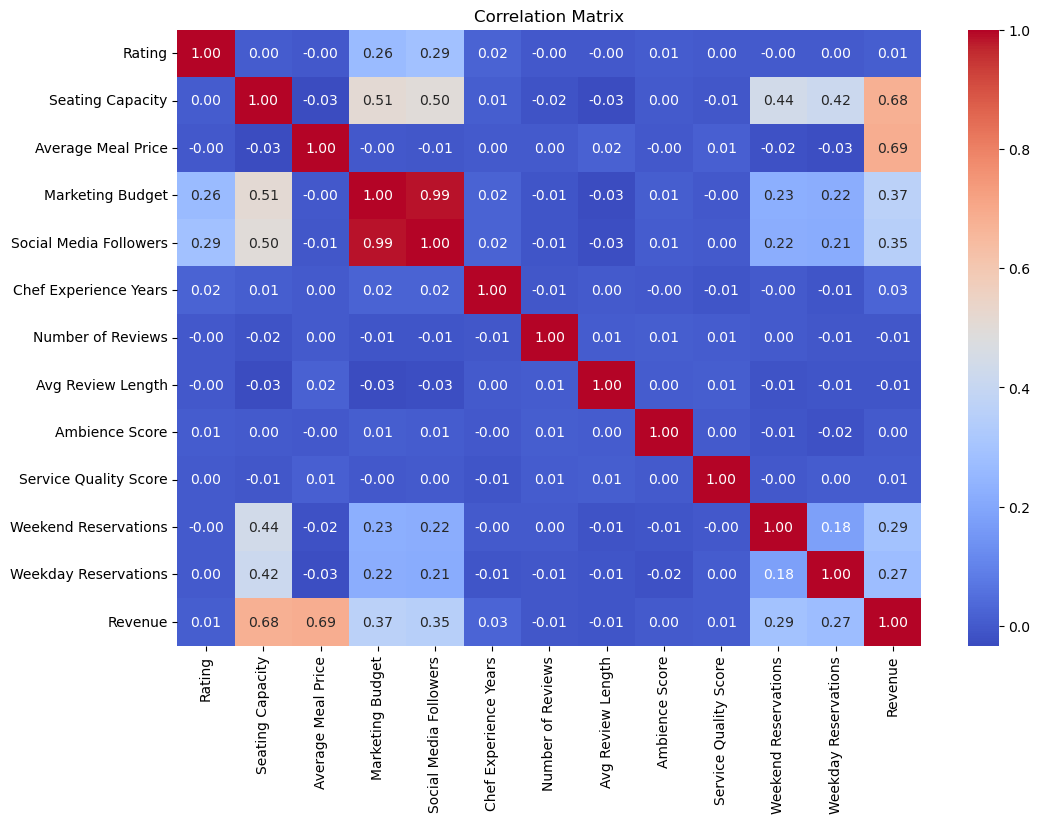

In [5]:
correlation_matrix = data.drop(columns=['Name', 'Location', 'Cuisine', 'Parking Availability']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

We can clearly see that marketing budget and social media followers are highly correlated. Let's combine them using Principal Component Analysis.

0   -0.870544
1    0.712762
2   -0.122085
3   -1.591078
4    0.314123
Name: Marketing&Followers, dtype: float64
Min: -2.152321772635307
Max: 5.1669598300579205
Mean: 3.821035266396332e-18
Median: -0.28507342533546887
Empty values: 0
Standard Deviation: 1.4098755110471624
Correlation between Marketing&Followers and Revenue: 0.3610230201168408
Correlation: 0.3610230201168408, p-value: 4.8606612970330075e-256
Mutual information: 0.08035572762588394


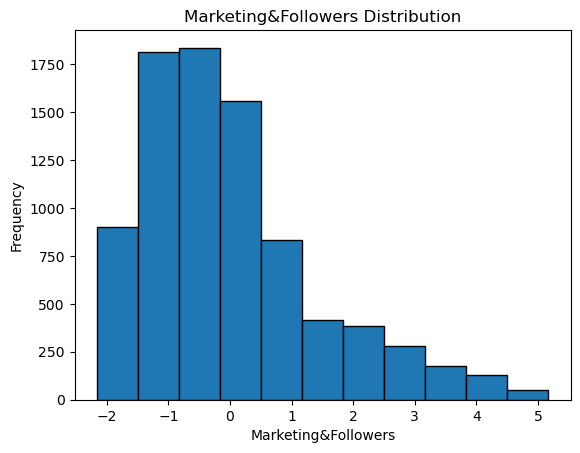

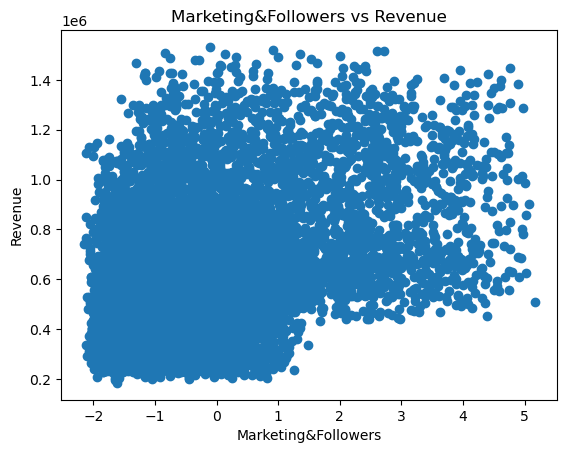

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the columns to use for PCA
columns = ['Social Media Followers', 'Marketing Budget']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Create a PCA object
pca = PCA(n_components=2, random_state=42)

new_column_name='Marketing&Followers'
data[new_column_name] = pca.fit_transform(data_scaled)[:, 0]

print(data[new_column_name].head())
show_data_stats(new_column_name, bins=11, target_property='Revenue')

A bit skewed but looks like a normal distribution so let's just apply normalization to it and that's it

## Revenue

Let's first look at the output value.

Min: 184708.52
Max: 1531867.55
Mean: 656070.5633508605
Median: 604242.085
Empty values: 0
Standard Deviation: 267413.7370301684


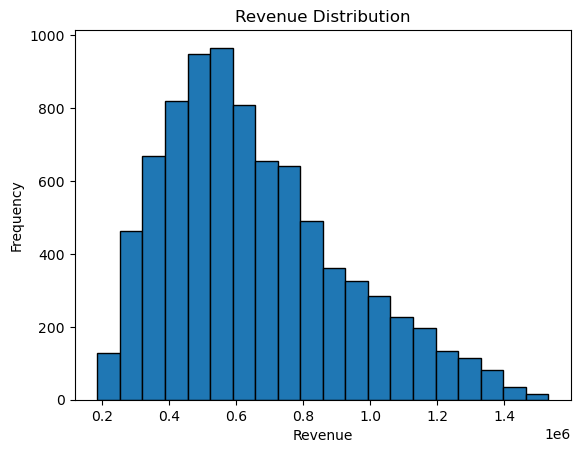

In [7]:
show_data_stats('Revenue', target_property=None)

Revenue distribution looks like quasi-normal distribution.

Now let's check the properties one by one.

## Location

Downtown: 2821
Suburban: 2785
Rural: 2762


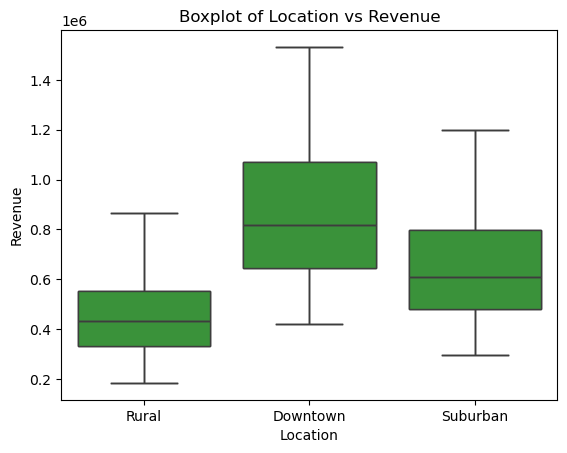

In [8]:
show_category_stats('Location')

Unsurprisingly, we see that being in downtown means that your revenue is generally higher.

## Cuisine

French: 1433
American: 1416
Italian: 1413
Mexican: 1393
Indian: 1369
Japanese: 1344


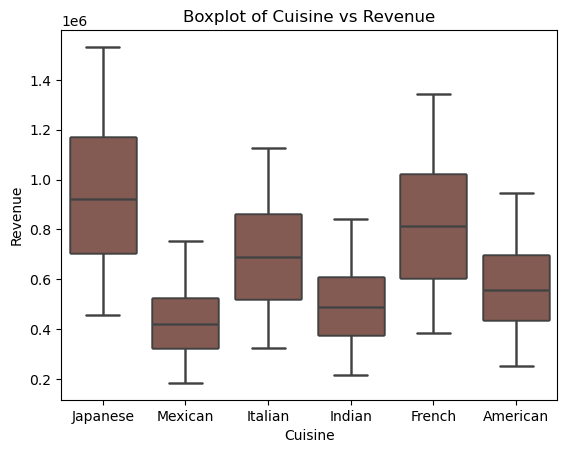

In [9]:
show_category_stats('Cuisine')

I am not a specialist so I see that the data points have quite long tails but it looks alright enough for me.

## Parking Availability

Yes: 4189
No: 4179


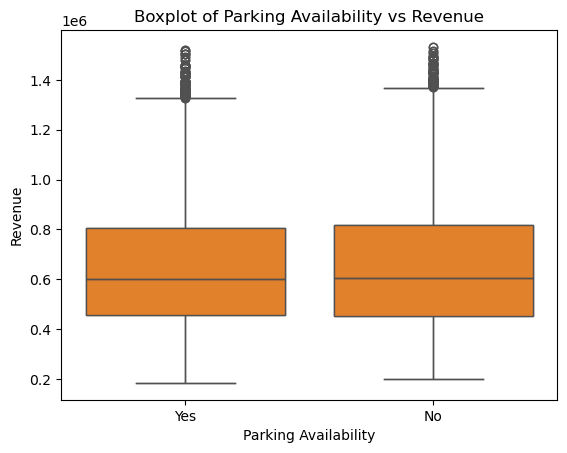

In [10]:
show_category_stats('Parking Availability')

We immediately see that this column has no direct importance to the revenue.
As the Revenue is (almost) normally distributed, let's perform the [t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html):

In [11]:
from scipy.stats import ttest_ind

yes_revenue = data[data['Parking Availability'] == 'Yes']['Revenue']
no_revenue = data[data['Parking Availability'] == 'No']['Revenue']

t_stat, p_value = ttest_ind(yes_revenue, no_revenue)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: -0.32451297258574446, p-value: 0.7455578159247318


p-value of 74% means that the value of Parking Availability almost certainly have no impact on the Revenue.

Let's check the interaction with other two categorical properties.

   Parking Availability_No  Parking Availability_Yes  Location_Downtown  \
0                    False                      True              False   
1                    False                      True               True   
2                     True                     False              False   
3                    False                      True              False   
4                     True                     False               True   

   Location_Rural  Location_Suburban  
0            True              False  
1           False              False  
2            True              False  
3            True              False  
4           False              False  


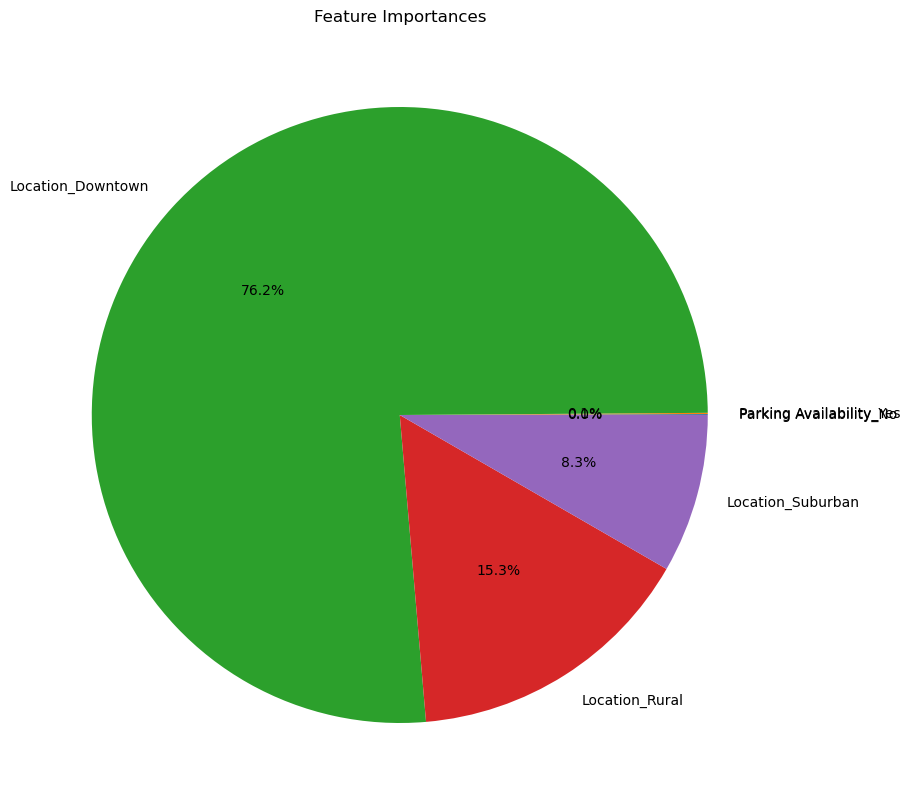

In [12]:
# Parking Availability * Location

dd = data[['Parking Availability', 'Location']]
X = pd.get_dummies(dd)
# debug output to ensure that we got the correct labels
print(X.head())

from sklearn.ensemble import RandomForestRegressor

y = data['Revenue']

# Get feature importances using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# according to the documentation, the importances sum up to 1
# so let's plot the importances as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(importances, labels=X.columns, autopct='%1.1f%%')
plt.title('Feature Importances')
plt.show()


As we see, for the random forest importance of parking availability compared to location was effectively zero.

Now, final check to be completely sure, same cross-check but with the Cuisine.

   Parking Availability_No  Parking Availability_Yes  Cuisine_American  \
0                    False                      True             False   
1                    False                      True             False   
2                     True                     False             False   
3                    False                      True             False   
4                     True                     False             False   

   Cuisine_French  Cuisine_Indian  Cuisine_Italian  Cuisine_Japanese  \
0           False           False            False              True   
1           False           False            False             False   
2           False           False             True             False   
3           False           False             True             False   
4           False           False            False              True   

   Cuisine_Mexican  
0            False  
1             True  
2            False  
3            False  
4            Fals

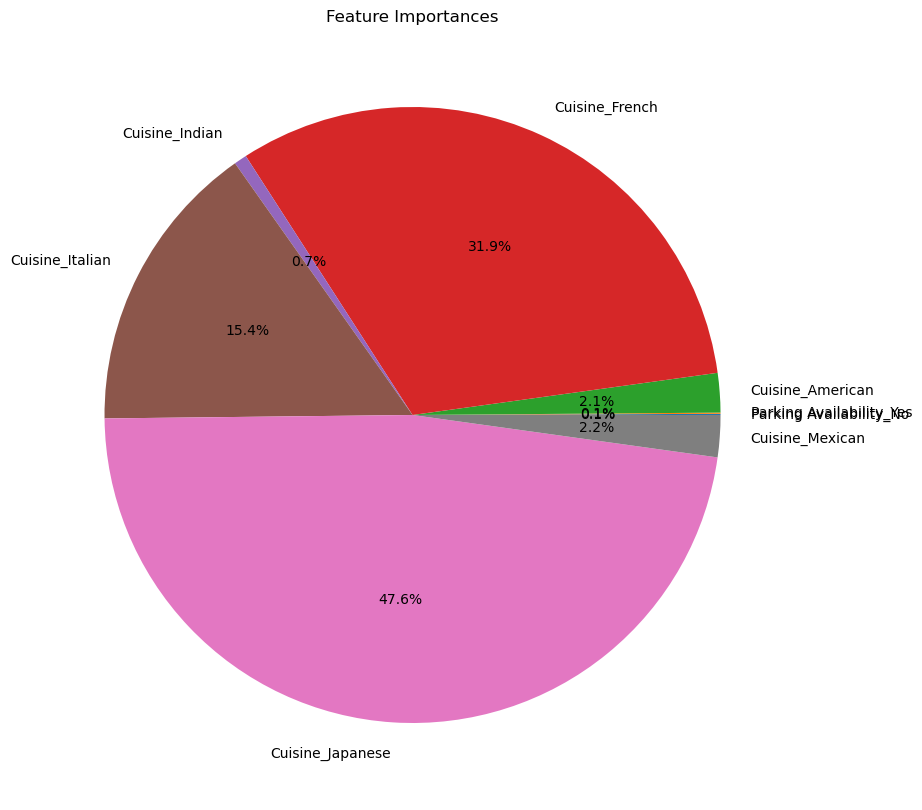

In [13]:
# Parking Availability * Cuisine

dd = data[['Parking Availability', 'Cuisine']]
X = pd.get_dummies(dd)
# debug output to ensure that we got the correct labels
print(X.head())

y = data['Revenue']

# Get feature importances using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# according to the documentation, the importances sum up to 1
# so let's plot the importances as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(importances, labels=X.columns, autopct='%1.1f%%')
plt.title('Feature Importances')
plt.show()


Same result as with Location. I will assume, then, that Parking Availability can be safely dropped from the dataset.

Location and cuisine counts are distributed evenly enough (is this dataset auto-generated at random?..), so I think the only thing we would need is to map the string values to integer numbers and nothing else.

## Rating

Min: 3.0
Max: 5.0
Mean: 4.008257648183556
Median: 4.0
Empty values: 0
Standard Deviation: 0.5814736080781615
Correlation between Rating and Revenue: 0.009899208062126987
Correlation: 0.00989920806212699, p-value: 0.36523523862484886
Mutual information: 0.0016995120068954428


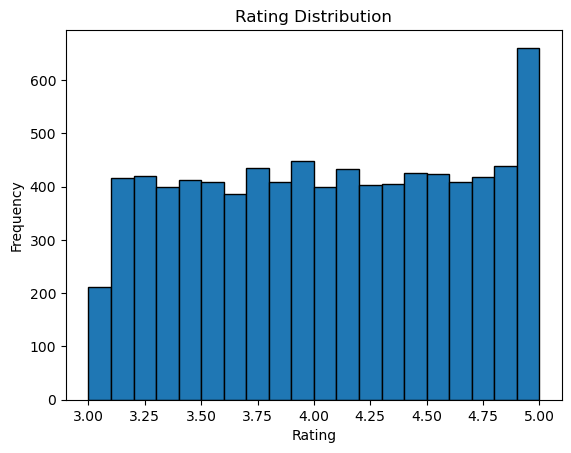

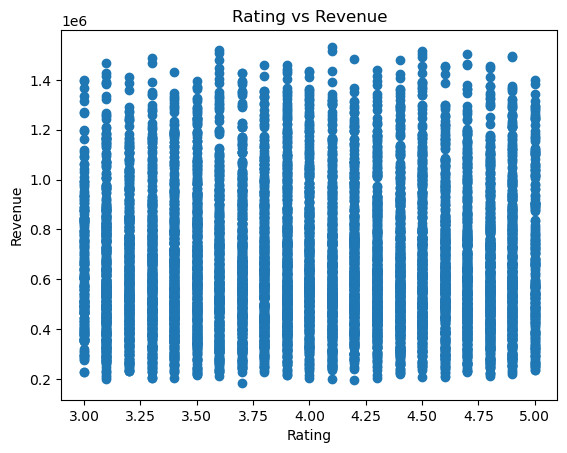

In [14]:
show_data_stats('Rating', bins=20)

We have multiple problems with this variable.

1. There's significantly lower than average amount of samples with rating 3
2. There's significantly higher than average amount of samples with rating 5
3. Scatterplot shows zero correlation between rating and revenue
4. Linear correlation coefficients between rating and revenue are almost zero (less than a promille)
5. Mutual information estimate, which I use to check for nonlinear dependencies, is less than a promille as well.

I think I can safely drop this variable from the dataset.

## Seating capacity

Min: 30
Max: 90
Mean: 60.21283460803059
Median: 60.0
Empty values: 0
Standard Deviation: 17.399488340801955
Correlation between Seating Capacity and Revenue: 0.6773172393918309
Correlation: 0.6773172393918305, p-value: 0.0
Mutual information: 0.47892423787961125


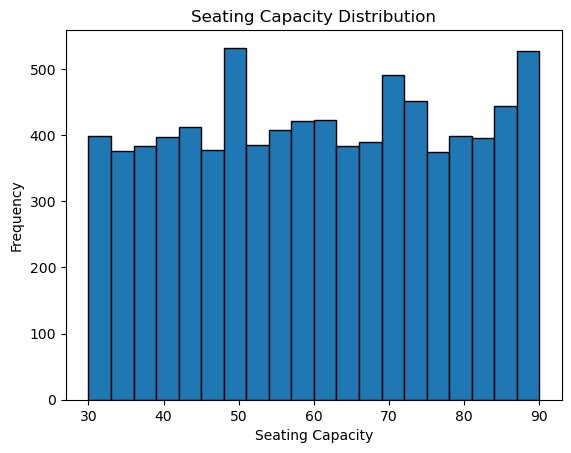

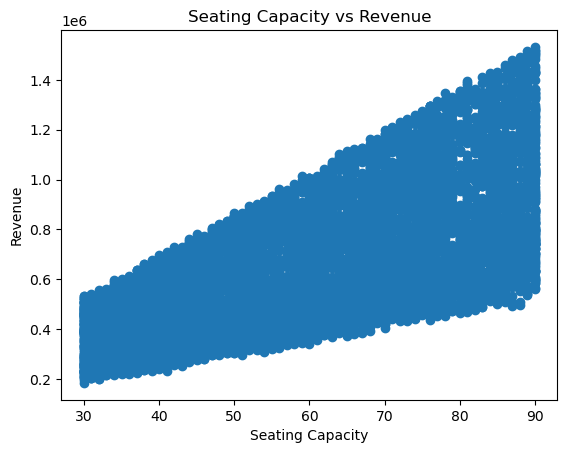

In [15]:
show_data_stats('Seating Capacity');

here we only apply normalization, we have one peak at 50 but it's not important enough

## Average meal price

Min: 25.0
Max: 76.0
Mean: 47.896658699808796
Median: 45.535
Empty values: 0
Standard Deviation: 14.336766739814099
Correlation between Average Meal Price and Revenue: 0.6863646811017292
Correlation: 0.6863646811017292, p-value: 0.0
Mutual information: 0.4746889846161899


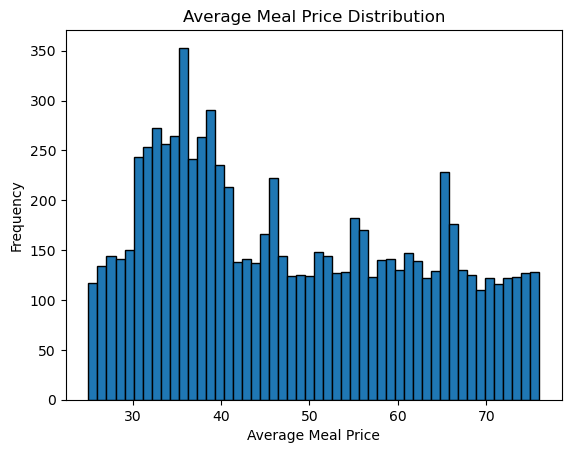

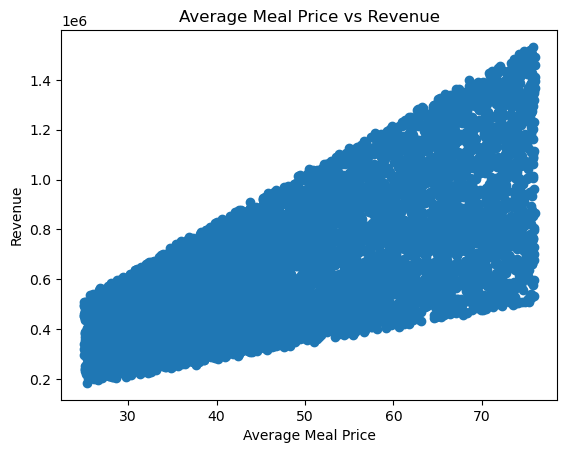

In [16]:
show_data_stats('Average Meal Price', bins=50);

This curve is a bit worrying but I think we can manage with just the normalization of values, too.

## Marketing Budget and Social Media Followers

These two columns has been converted to a single new column "Marketing&Followers", for uniformity let's show it again

Min: -2.152321772635307
Max: 5.1669598300579205
Mean: 3.821035266396332e-18
Median: -0.28507342533546887
Empty values: 0
Standard Deviation: 1.4098755110471624
Correlation between Marketing&Followers and Revenue: 0.3610230201168408
Correlation: 0.3610230201168408, p-value: 4.8606612970330075e-256
Mutual information: 0.08035635658834739


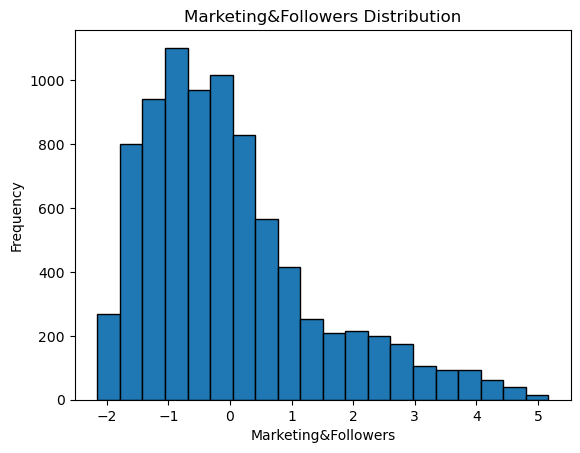

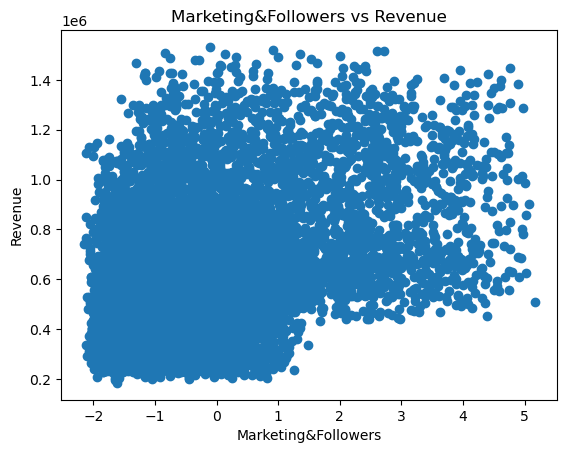

In [17]:
show_data_stats('Marketing&Followers');

## Marketing Budget

Let's check the Marketing Budget separately

Min: 604
Max: 9978
Mean: 3218.254899617591
Median: 2846.5
Empty values: 0
Standard Deviation: 1824.8960526888375
Correlation between Marketing Budget and Revenue: 0.36532204505056887
Correlation: 0.3653220450505688, p-value: 1.4028767226810881e-262
Mutual information: 0.10161078622593056


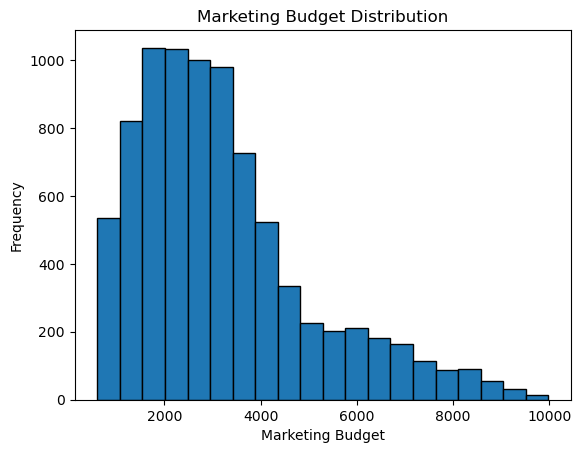

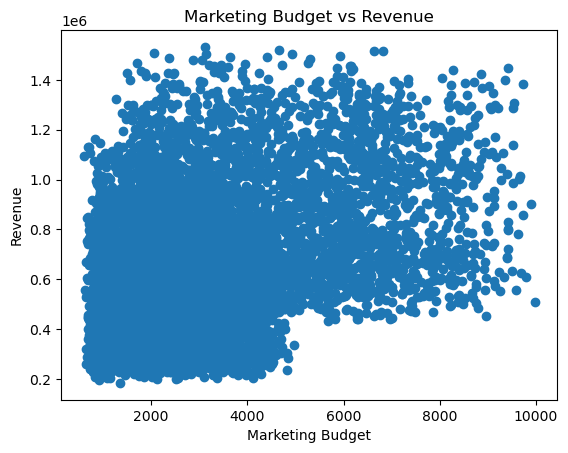

In [18]:
show_data_stats('Marketing Budget');

## Social Media Followers

Now the Social Media Followers

Min: 5277
Max: 103777
Mean: 36190.621773422565
Median: 32518.5
Empty values: 0
Standard Deviation: 18630.153329916502
Correlation between Social Media Followers and Revenue: 0.3544661316274186
Correlation: 0.3544661316274186, p-value: 2.939127392575814e-246
Mutual information: 0.08518495082570876


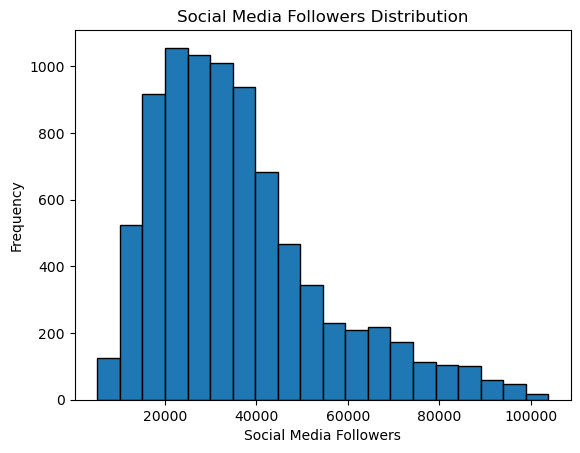

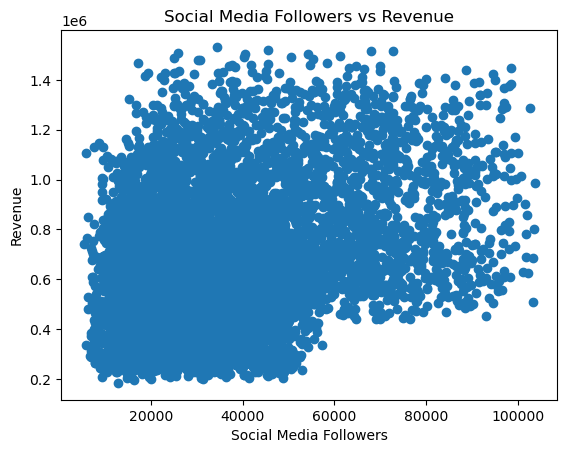

In [19]:
show_data_stats('Social Media Followers')

Indeed, we can combine these two into a single metric. Even just by looking at scatterplots we can guess that these two variables hold the same information.

## Chef Experience Years

Min: 1
Max: 19
Mean: 10.051983747609942
Median: 10.0
Empty values: 0
Standard Deviation: 5.516605603208737
Correlation between Chef Experience Years and Revenue: 0.02689904296260485
Correlation: 0.02689904296260487, p-value: 0.013866035933502654
Mutual information: 0.004039668769562077


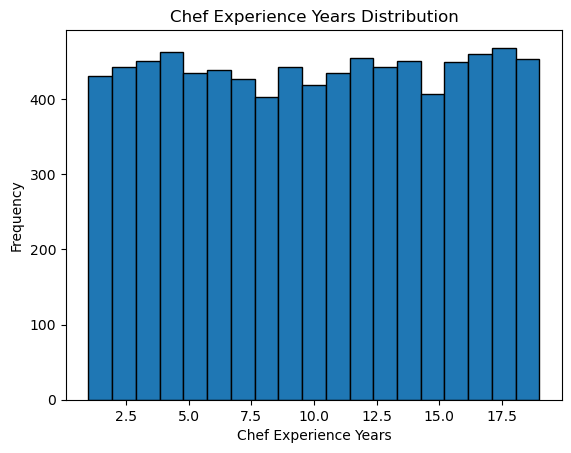

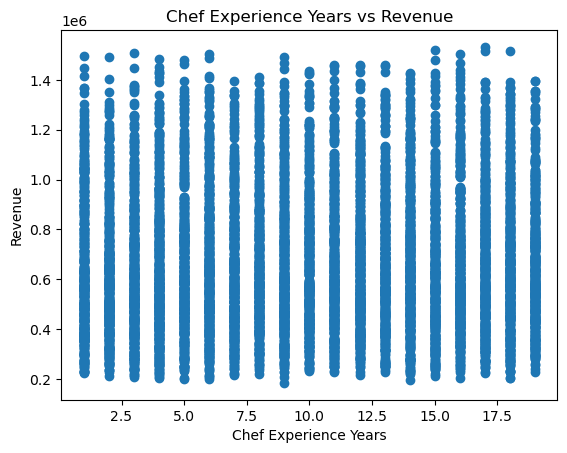

In [20]:
show_data_stats('Chef Experience Years', bins=19)

At the first glance looks like yet another useless metric as Rating was. We have just 19 different values, let's check this variable as a categorical one:

18: 468
4: 462
17: 459
12: 455
19: 453
14: 451
3: 450
16: 449
2: 443
9: 442
13: 442
6: 439
5: 435
11: 434
1: 431
7: 426
10: 419
15: 407
8: 403


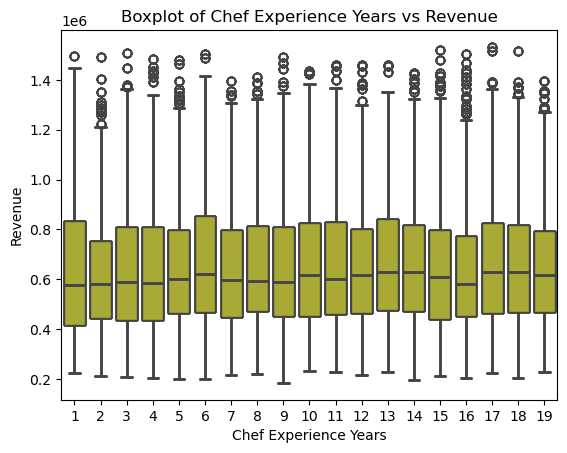

In [21]:
show_category_stats('Chef Experience Years')

We see almost exactly the same picture as with the Parking Availability. Let's quickly perform the same check as we did with that variable, except that now we have 19 values instead of 2.

For the `ttest_ind` 19 values means $C(19,2) = 171$ pair to check. This is quite a lot so let's apply [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html) as well.

In [22]:
from scipy.stats import ttest_ind

column_name = 'Chef Experience Years'
target_column_name = 'Revenue'
possible_values = data[column_name].unique()

p_values = []
for i in range(len(possible_values)):
    for j in range(i + 1, len(possible_values)):
        value_i = possible_values[i]
        value_j = possible_values[j]
        revenue_i = data[data[column_name] == value_i][target_column_name]
        revenue_j = data[data[column_name] == value_j][target_column_name]
        t_stat, p_value = ttest_ind(revenue_i, revenue_j)
        print(f"Comparing {value_i} vs {value_j}: t-statistic = {t_stat}, p-value = {p_value}")
        p_values.append(p_value)

# Bonferroni correction
alpha = 0.05
n_tests = len(p_values)
adjusted_alpha = alpha / n_tests
significant_tests = [p_value < adjusted_alpha for p_value in p_values]
print(f"Number of significant tests: {sum(significant_tests)}")
print(f"Total number of tests: {n_tests}")


Comparing 13 vs 8: t-statistic = 0.5803808236675086, p-value = 0.5618129351382769
Comparing 13 vs 18: t-statistic = 0.4400380813588168, p-value = 0.6600142484308084
Comparing 13 vs 9: t-statistic = 1.301672759111803, p-value = 0.19336814688560966
Comparing 13 vs 5: t-statistic = 1.103040447402331, p-value = 0.2703128753711038
Comparing 13 vs 11: t-statistic = 0.7503346474359276, p-value = 0.45325512361267084
Comparing 13 vs 14: t-statistic = 0.39784259393862986, p-value = 0.6908415166568893
Comparing 13 vs 16: t-statistic = 1.3760343833603055, p-value = 0.16915752077352747
Comparing 13 vs 4: t-statistic = 1.6609202613436918, p-value = 0.09707698439920276
Comparing 13 vs 19: t-statistic = 0.9994325337382054, p-value = 0.3178559404774882
Comparing 13 vs 2: t-statistic = 2.701557256697684, p-value = 0.007033857569227224
Comparing 13 vs 17: t-statistic = 0.46536536624396985, p-value = 0.6417825387384435
Comparing 13 vs 6: t-statistic = 0.025019860712182186, p-value = 0.9800448007238486
Com

Between any pair of chef experience years, the average revenue is the same, meaning, no matter which pair of experience we pick, it will not divide the revenue in any meaningful way.

We can conclude with some degree of confidence that we can drop the "Chef Experience Years" from the dataset as well.

## Number of Reviews

Min: 50
Max: 999
Mean: 523.010396749522
Median: 528.0
Empty values: 0
Standard Deviation: 277.21512739200216
Correlation between Number of Reviews and Revenue: -0.008232545386266537
Correlation: -0.008232545386266533, p-value: 0.45145776110017943
Mutual information: 0.004375743522031961


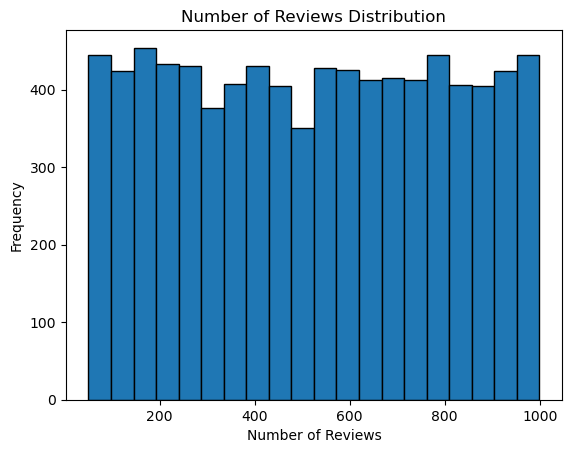

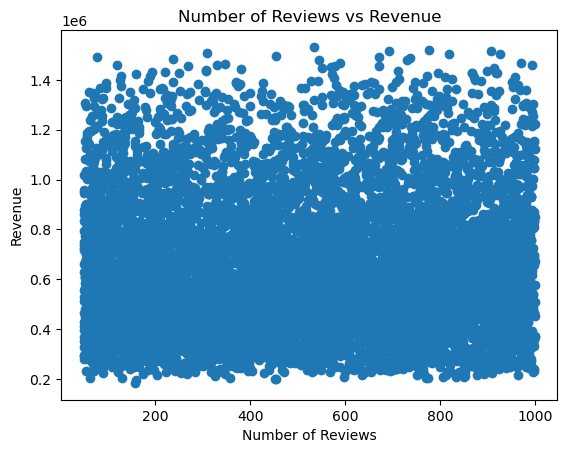

In [23]:
show_data_stats('Number of Reviews')

This property looks the same as Chef Experience Years

## Average Review Length

Min: 50.01171744790162
Max: 299.9849240114296
Mean: 174.76997428864198
Median: 173.91007932928522
Empty values: 0
Standard Deviation: 71.99805967298204
Correlation between Avg Review Length and Revenue: -0.011277799433412651
Correlation: -0.011277799433412651, p-value: 0.30228982477206195
Mutual information: 0.0011972154400252677


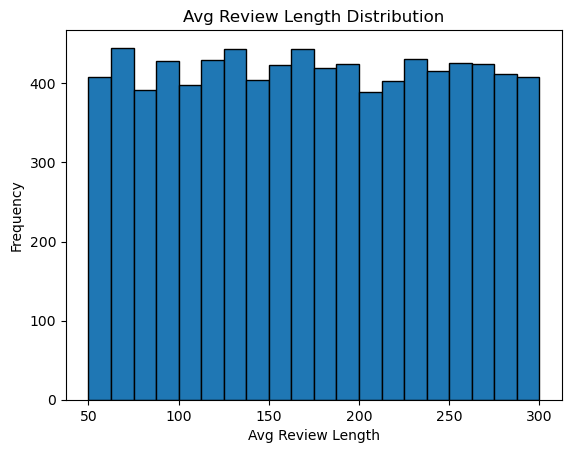

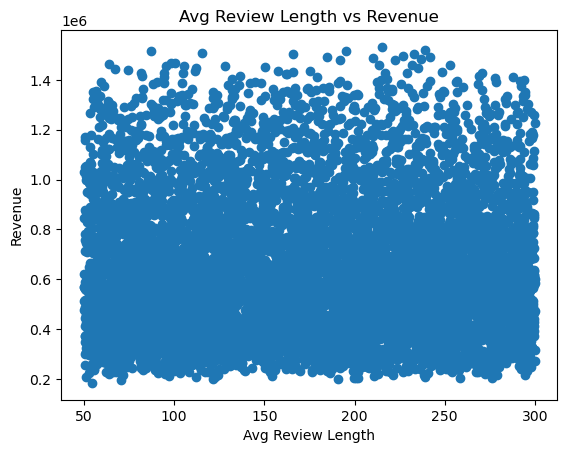

In [24]:
show_data_stats('Avg Review Length')

Again, no visible direct relation

## Ambience Score

Chose 100 bins for the histogram because the range is 1-10 and the precision is 0.1

Min: 1.0
Max: 10.0
Mean: 5.521283460803059
Median: 5.5
Empty values: 0
Standard Deviation: 2.5754422924516582
Correlation between Ambience Score and Revenue: 0.0033876394916735656
Correlation: 0.0033876394916735617, p-value: 0.756678887444854
Mutual information: 0.001402801436418244


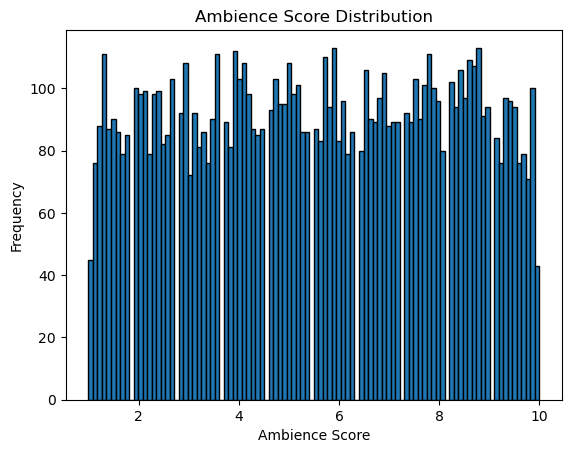

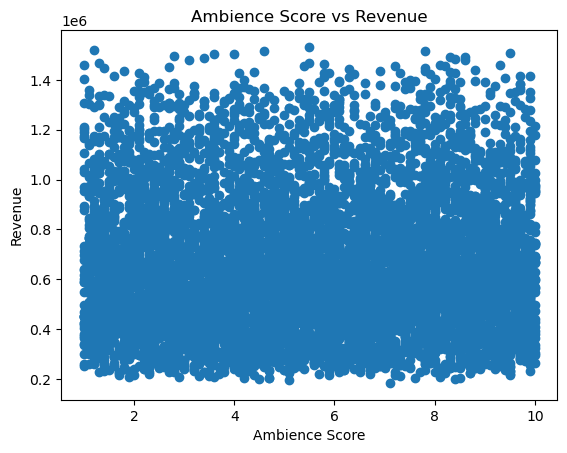

In [25]:
show_data_stats('Ambience Score', bins=100)

Same noise as the previous three variables

## Service Quality Score

Min: 1.0
Max: 10.0
Mean: 5.508771510516253
Median: 5.6
Empty values: 0
Standard Deviation: 2.5865520917955727
Correlation between Service Quality Score and Revenue: 0.005375197687928376
Correlation: 0.005375197687928375, p-value: 0.6229768060737009
Mutual information: 0


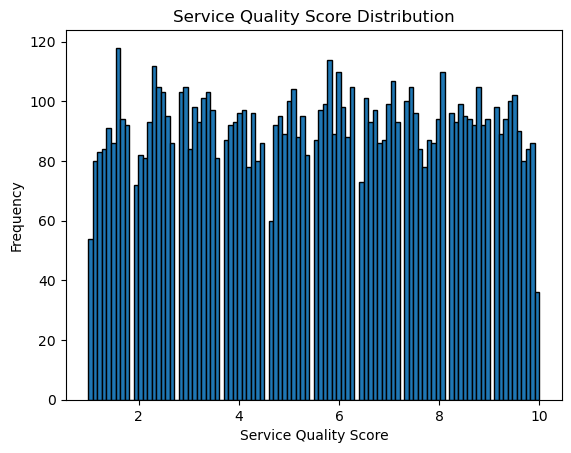

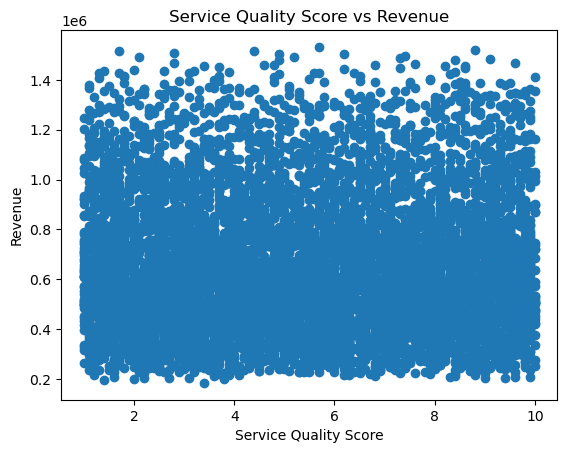

In [26]:
show_data_stats('Service Quality Score', bins=100)

This variable has mutual information estimation at 0 (!) meaning that our estimation decided that the Service Quality Score and Revenue are completely independent.

## Weekend Reservations

Min: 0
Max: 88
Mean: 29.49175430210325
Median: 27.0
Empty values: 0
Standard Deviation: 20.025415401114603
Correlation between Weekend Reservations and Revenue: 0.29240021357969953
Correlation: 0.2924002135796994, p-value: 1.2876471962522268e-164
Mutual information: 0.07101200020431708


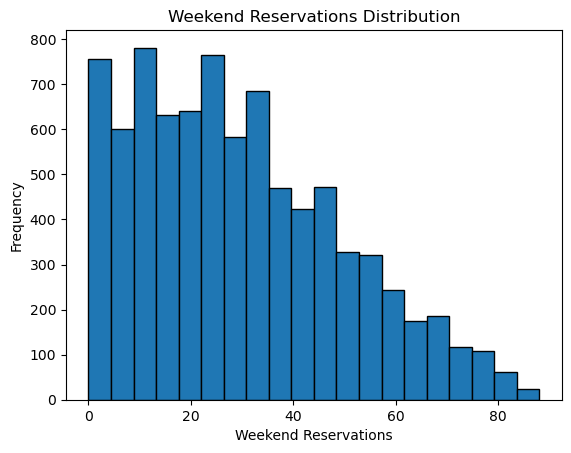

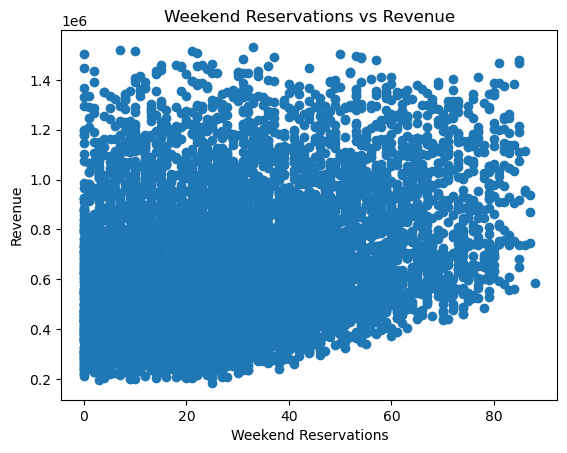

In [27]:
show_data_stats('Weekend Reservations')

This variable sports a minuscule p-value meaning that the revenue is probably actually linearly dependent on it.

## Weekday Reservations

Min: 0
Max: 88
Mean: 29.235301147227535
Median: 26.0
Empty values: 0
Standard Deviation: 20.00427733644612
Correlation between Weekday Reservations and Revenue: 0.27328369507140476
Correlation: 0.2732836950714047, p-value: 3.124836289368541e-143
Mutual information: 0.05659902241277237


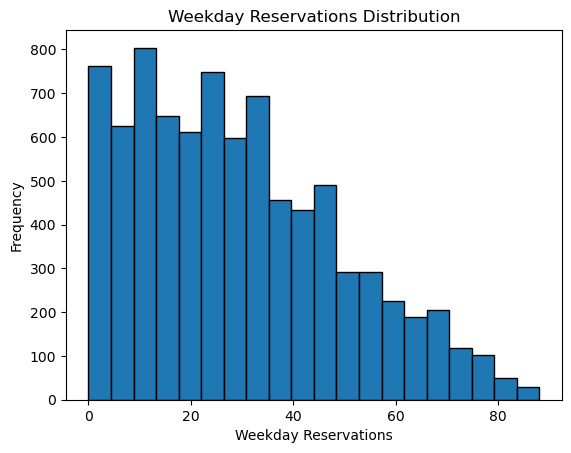

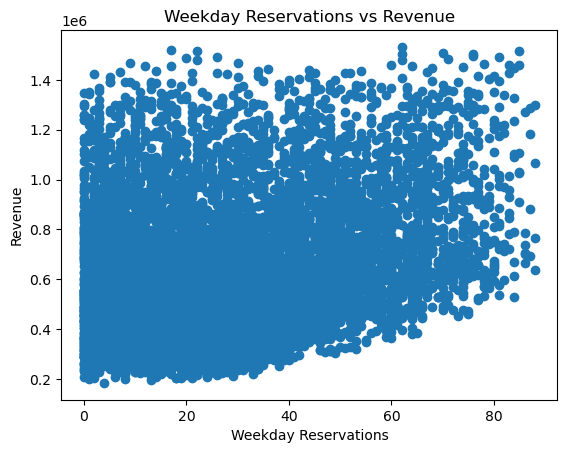

In [28]:
show_data_stats('Weekday Reservations')

This variable has the same significance as the Weekend Reservations. We can guess that these two variables are actually impactful for revenue estimation.

## Conclusions

We will prepare two datasets.

One dataset will include all the variables from the original dataset.
This is to ensure that we didn't lose any hidden dependencies in the data.

Second dataset will exclude all the variables which we noticed have no correlation with the output variable (revenue).
That is:

1. Parking Availability
2. Rating
3. Chef Experience Years
4. Number of Reviews
5. Avg Review Length
6. Ambience Score
7. Service Quality Score

It is illogical that all these variables do not influence the revenue at all, because most of them describe the actual qualities of the restaurants, especially chef experience years and parking availability (which are objective characteristics).

However, history shows that the nature of science is hard data, not our "common sense".

We will evaluate the model on both these datasets and compare the prediction efficiency. If dropping these properties don't influence the error rate, then we can conclude that all these properties are not the reasons for the revenue of the restaurant.



In [30]:
# make a copy of the data
data_copy = data.copy()

# these three columns we drop immediately, one is not needed, and the other two we combined into one using PCA
data_copy = data_copy.drop(columns=['Name', 'Marketing Budget', 'Social Media Followers'])

# convert location, cuisine and parking availability to one-hot encoding
data_copy = pd.get_dummies(data_copy, columns=['Location', 'Cuisine', 'Parking Availability'])

data_copy.to_csv('data/full_dataset.csv', index=False);

# now drop the columns that are not needed
columns_to_drop = ['Rating', 'Parking Availability_Yes', 'Parking Availability_No', 'Chef Experience Years', 'Number of Reviews', 'Avg Review Length', 'Ambience Score', 'Service Quality Score']
data_reduced = data_copy.drop(columns=columns_to_drop)

# write the resulting dataset to a second new CSV file
data_reduced.to_csv('data/reduced_dataset.csv', index=False)


So, we have three CSV files in the `data` folder:

1. `restaurant_data.csv` - this is raw unedited source dataset
2. `full_dataset.csv` - this is the raw dataset without the Name, Marketing Budget and Social Media Followers columns, with all categoric columns transformed to one-hot encoding
3. `reduced_dataset.csv` - this is the `full_dataset.csv` but without the columns which we decided to have no correlation with the revenue. This is our "main" dataset to work with, already prepared for use.

---